In [11]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [10]:
pip install matplotlib pandas scikit-learn

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 11.3 MB 5.5 MB/s eta 0:00:01
     |████████████████████████████████| 11.1 MB 46.1 MB/s eta 0:00:01
     |████████████████████████████████| 346 kB 50.0 MB/s eta 0:00:01
     |████████████████████████████████| 507 kB 62.7 MB/s eta 0:00:01
     |████████████████████████████████| 301 kB 43.7 MB/s eta 0:00:01
     |████████████████████████████████| 30.3 MB 43.2 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [64]:
# Etape 1 - Chargement des données
df = pd.read_csv('./data/employee-earnings-report-2021.csv', encoding='ISO-8859-1')

# Etape 2 - On enlève les lignes vides et inutiles
df = df.dropna(how='all')

# Etape 5 - Préparation des données pour prédiction
removed_columns = ['NAME', 'TITLE', 'POSTAL']

# Ces colonnes ne sont pas pertinentes pour prédire les valeurs
df.drop(removed_columns, axis=1, inplace=True)

# Etape 3 - Convertir en valeurs numériques Python
numeric_columns = ['REGULAR', 'RETRO', 'OTHER', 'OVERTIME', 'INJURED', 'DETAIL', 'QUINN_EDUCATION_INCENTIVE', 'TOTAL_GROSS']

def clean_numeric_column(column):
    # On supporte le format numérique monétaire bizarre des états-unis
    return column.apply(lambda x: str(x).replace(',', '') if isinstance(x, str) else x).astype(float)

for column in numeric_columns:
    df[column] = clean_numeric_column(df[column])
    #df[column] = df[column].fillna(0)

print(df)

                    DEPARTMENT_NAME    REGULAR  RETRO       OTHER  OVERTIME  \
0          Boston Police Department        NaN    NaN  1264843.63       NaN   
1          Boston Police Department        NaN    NaN  1252990.81       NaN   
2          Boston Police Department   69772.10    NaN   212739.48  82300.87   
3          Boston Police Department  100963.38    NaN   211900.28  67849.66   
4          Boston Police Department  109858.02    NaN   192097.54  75938.65   
...                             ...        ...    ...         ...       ...   
22541         BPS Special Education        NaN  69.86         NaN       NaN   
22542  BPS Substitute Teachers/Nurs        NaN    NaN         NaN     59.78   
22543           Tech Boston Academy        NaN    NaN       56.62       NaN   
22544          Food & Nutrition Svc      54.00    NaN         NaN       NaN   
22545         Boston Public Library       1.00    NaN       25.00       NaN   

        INJURED   DETAIL  QUINN_EDUCATION_INCENTIVE

In [70]:
# Etape 4 - Chercher des données aberrantes

model = IsolationForest()
df['outlier'] = model.fit_predict(df[numeric_columns])
outliers = df[df['outlier'] == -1]
outlier_count = len(outliers)

print(f"Number of outliers detected: {outlier_count}")

outliers

# TODO Remove the 6 most likely outliers

Number of outliers detected: 3190


,DEPARTMENT_NAME,REGULAR,RETRO,OTHER,OVERTIME,INJURED,DETAIL,QUINN_EDUCATION_INCENTIVE,TOTAL_GROSS,outlier
0,114,NaN,NaN,1264843.63,NaN,NaN,NaN,NaN,1264843.63,-1
1,114,NaN,NaN,1252990.81,NaN,NaN,NaN,NaN,1252990.81,-1
2,114,69772.10,NaN,212739.48,82300.87,30939.24,12144.0,25178.06,433073.75,-1
3,114,100963.38,NaN,211900.28,67849.66,NaN,9016.0,10096.55,399825.87,-1
4,114,109858.02,NaN,192097.54,75938.65,NaN,19550.0,NaN,397444.21,-1
...,...,...,...,...,...,...,...,...,...,...
22329,197,10.00,NaN,741.20,194.58,NaN,NaN,NaN,945.78,-1
22330,199,833.86,NaN,NaN,714.48,-604.59,NaN,NaN,943.75,-1
22373,115,716.54,NaN,NaN,30.71,NaN,NaN,NaN,747.25,-1
22378,197,655.56,NaN,NaN,73.75,NaN,NaN,NaN,729.31,-1


In [69]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['DEPARTMENT_NAME'] = le.fit_transform(df['DEPARTMENT_NAME'].fillna('Unknown'))

# Séparation des données en attributs et cible
X = df[numeric_columns]
y = df['DEPARTMENT_NAME']

# Division en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

# Méthodes d'imputation
imputers = {
    'zero': SimpleImputer(strategy='constant', fill_value=0),
    'median': SimpleImputer(strategy='median'),
    'KNN': KNNImputer(n_neighbors=5),
    'iterative': IterativeImputer(max_iter=10)
}

# Classifiers
classifiers = {
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier()
}

# Fonction pour évaluer les modèles et calculer les scores F1
def evaluate_models(imputer, classifier):
    # Applique l'imputation sur l'ensemble d'entraînement
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)

    # Entraînement du classifieur
    classifier.fit(X_train_imputed, y_train)

    # Prédiction
    y_pred = classifier.predict(X_test_imputed)

    # Calcul des scores F1 micro et macro
    f1_micro = f1_score(y_test, y_pred, average='micro')
    f1_macro = f1_score(y_test, y_pred, average='macro')

    return f1_micro, f1_macro

# Test des combinaisons d'imputation et de classifieurs
results = []
for imputer_name, imputer in imputers.items():
    for clf_name, clf in classifiers.items():
        f1_micro, f1_macro = evaluate_models(imputer, clf)
        results.append((imputer_name, clf_name, f1_micro, f1_macro))

# Conversion des résultats en DataFrame pour affichage
import pandas as pd
results_df = pd.DataFrame(results, columns=['Imputer', 'Classifier', 'F1 Micro', 'F1 Macro'])


KeyboardInterrupt: 

In [66]:
results_df

,Imputer,Classifier,F1 Micro,F1 Macro
0,zero,KNN,0.226164,0.046125
1,zero,Decision Tree,0.264745,0.063711
2,zero,Random Forest,0.275831,0.066850
3,median,KNN,0.229712,0.046993
4,median,Decision Tree,0.262084,0.069340
5,median,Random Forest,0.272284,0.066669
6,KNN,KNN,0.213304,0.044173
7,KNN,Decision Tree,0.240355,0.058258
8,KNN,Random Forest,0.259867,0.060681
9,iterative,KNN,0.232816,0.046893


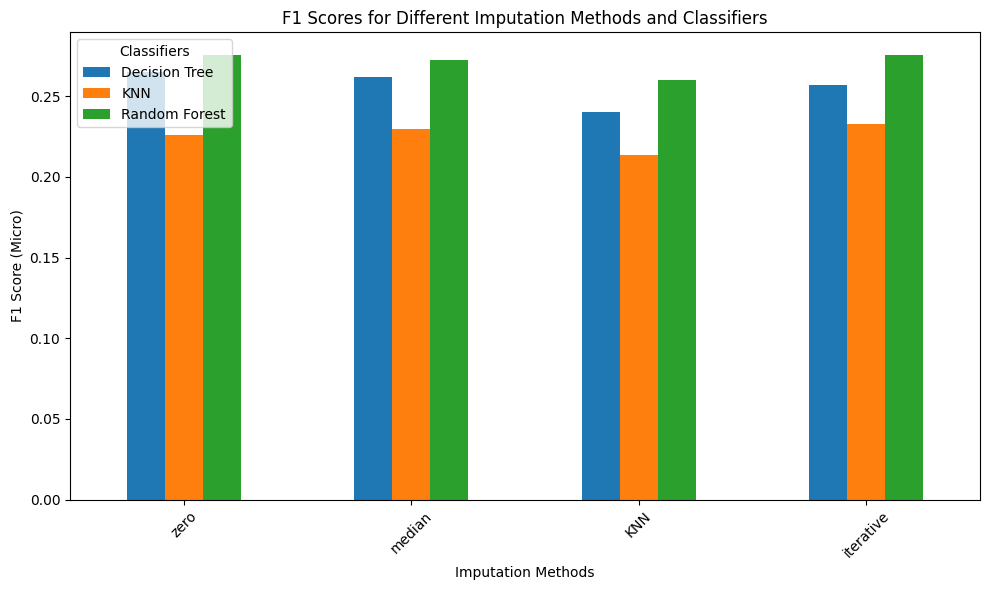

In [68]:
# Step 8: Affichage sous forme de graphe avec Matplotlib
fig, ax = plt.subplots(figsize=(10, 6))

imputation_order = ['zero', 'median', 'KNN', 'iterative']

pivot_df = results_df.pivot(index='Imputer', columns='Classifier', values='F1 Micro')
pivot_df = pivot_df.loc[imputation_order]

pivot_df.plot(kind='bar', ax=ax)

ax.set_title("F1 Scores for Different Imputation Methods and Classifiers")
ax.set_xlabel("Imputation Methods")
ax.set_ylabel("F1 Score (Micro)")
ax.legend(title="Classifiers")
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

## Questions & Réponses

### Etape 2

> Combien de lignes et de colonnes a le Data Frame ?

`22552` lignes et `12` colonnes.

> Pour chaque colonne, combien y a-t-il de
données manquantes ?

- **NAME**: 6
- **DEPARTMENT_NAME**: 6
- **TITLE**: 6
- **REGULAR**: 644
- **RETRO**: 22,150
- **OTHER**: 8,423
- **OVERTIME**: 15,706
- **INJURED**: 21,096
- **DETAIL**: 20,493
- **QUINN_EDUCATION_INCENTIVE**: 21,166
- **TOTAL_GROSS**: 6
- **POSTAL**: 6

> Y a-t-il des lignes entièrement vides ?

Oui, il y en a 6.

### Etape 6

> Existe-t-il des classifieurs dans Scikit-learn qui acceptent des données manquantes ?

Oui, nous avons trouvé ce classifieur dans la doc de scikit-learn :

**HistGradientBoostingClassifier** ([Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html))

### Etape 7

> Si on attribue à tous les items la classe majoritaire, quel score F1 avec micro-moyenne obtient-on ? (On peut répondre par un simple calcul.)

> Quelle est la combinaison parmi les 12 qui a le meilleur score F1 avec micro-moyenne ?

> Comment se comparent les scores F1 avec micro-moyenne par rapport à ceux calculés avec une macro-moyenne